In [25]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import itertools
import random
import time
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from scipy.stats import norm
from util import pickle_load, robust_z

In [26]:
# validation test name
test_num = "0701"
lig = "!"

In [27]:
date = 241219
num = 1
trys = str(date) + "_" + str(num)

In [28]:
if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 

In [29]:
all_smiles = []
for i in range(len(cas_tox)):
    all_smiles.append(cas_tox.iloc[i,2])

molecules = [Chem.MolFromSmiles(smiles) for smiles in all_smiles]

In [30]:
fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

In [31]:
pops = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/top_5.tsv", sep="\t", header=None)

In [32]:
def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    toxicity_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "discrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        mean = len(individual) / 2
        std_dev = len(individual) / 10
        toxicity_score = norm.pdf(x=count_t, loc=mean, scale=std_dev) * 1000

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]

        structure = dict_t[0]
        phisical = dict_t[1]

        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [33]:
best_pop = pops.iloc[-1,0]
tox_scoring = "continuous"

IND_INIT_SIZE = len(val)

all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "discrete":
    standardized_toxs = all_toxs

best_pop = best_pop.replace("Individual(", "").replace(")", "")
best_pop = list(ast.literal_eval(best_pop))
best_score = multi_objective_optimization(best_pop)

color = []
for i in range(len(cas_tox)):
    if i in best_pop:
        color.append("red")
    else:
        color.append("blue")

(115.15139331880815, 187.30823989219212, 6.9799775997023055)


/opt/pip-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


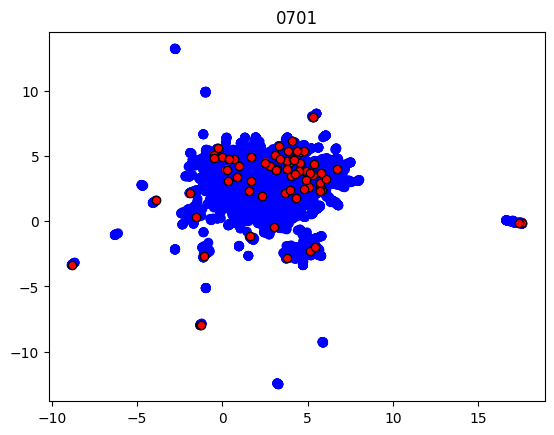

In [34]:
print(best_score)
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(fp)
embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]
plt.scatter(embedding_x, embedding_y, c=color, linewidths=1)
plt.scatter([embedding_x[i] for i in best_pop],  [embedding_y[i] for i in best_pop], c='red', ec='black', linewidth=1)
plt.title(f"{test_name}")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/UMAP_[-1,0].png")
plt.show()